Below is the gene level analysis

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

#import rpy2.rinterface_lib.callbacks
#import logging

#from rpy2.robjects import pandas2ri
#import anndata2ri

import h5py
import collections
import scipy.sparse as sp_sparse
import tables

/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/Applications/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from sinfo import sinfo
sinfo()

-----
gprofiler 	1.0.0
h5py      	2.9.0
matplotlib	3.1.3
numpy     	1.18.1
pandas    	1.0.2
scanpy    	1.4.3
scipy     	1.4.1
seaborn   	0.9.0
tables    	3.5.2
-----
IPython   	7.13.0
jupyter_client	6.0.0
jupyter_core	4.6.1
jupyterlab	1.2.6
notebook  	6.0.3
-----
Python 3.7.0 (default, Jun 28 2018, 07:39:16) [Clang 4.0.1 (tags/RELEASE_401/final)]
Darwin-16.7.0-x86_64-i386-64bit
4 logical CPU cores, i386
-----
Session information updated at 2020-03-21 21:56


Load in the data

In [3]:
adataa = sc.read_10x_h5('/Users/Vyom/data/AAPge.h5', genome=None, gex_only=True)
adataa.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [4]:
adatac = sc.read_10x_h5("/Users/Vyom/data/Controlpge.h5", genome=None, gex_only=True)
adatac.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adatap = sc.read_10x_h5("/Users/Vyom/data/PGE.h5", genome=None, gex_only=True)
adatap.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [6]:
# merge datasets
adata1 = adatac.concatenate(adataa, adatap, batch_key='Sample', batch_categories=['Control','AA', 'PGE'])

In [7]:
# Checking the total size of the data set
adata1.shape

(26434, 28692)

In [8]:
#Filter genes that are not expressed in many cells(threshold min: 5):
print('Total number of genes: {:d}'.format(adata1.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata1, min_cells=5)
print('Number of genes after cell filter: {:d}'.format(adata1.n_vars))

Total number of genes: 28692
Number of genes after cell filter: 16675


In [9]:
# Calculate normalized values for counts 
adata1.obs['n_counts'] = adata1.X.sum(1)
adata1.obs['log_counts'] = np.log(adata1.obs['n_counts'])
adata1.obs['n_genes'] = (adata1.X > 0).sum(1)

Identify number genes and counts and conduct log transformation of the counts

In [10]:
# filter cells that have produced less than 200 counts
sc.pp.filter_cells(adata1, min_counts=200)
# filter genes expressed in less than 3 cells
sc.pp.filter_genes(adata1, min_cells=3)

### Define gene sets for QC metrics

Cell stress increases variability and introduces bias. As a result, it is necessary to account for cells that are high in stress as their trancriptome would vary significanly from the viable sample thus skewing results. The proportion of mitochrondrial and ribosomal counts are metrics for cell stress. Cells with an elevated proportion of mitochrondrial and ribosomal counts are exempt from the sample.

In [11]:
# define mitochondrial and ribosomal genes
mito_genes = [name for name in adata1.var_names if name.startswith('mt-')]
Rpl_genes = [name for name in adata1.var_names if name.startswith('Rpl')]
Rps_genes = [name for name in adata1.var_names if name.startswith('Rps')]
ribo_genes = Rpl_genes + Rps_genes
# for each cell compute fraction of counts in mito genes vs. all genes
# the ".A1" is only necessary, as X is sparse - it transform to a dense array after summing
adata1.obs['percent_mito'] = np.sum(
    adata1[:, mito_genes].X, axis=1) / np.sum(adata1.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata1.obs['n_counts'] = np.sum(adata1.X, axis=1)
#Count IEG genes and calculate percentage per cell
#adata.obs['percent_IEG'] = np.sum(
#    adata[:, IEG].X, axis=1) / np.sum(adata.X, axis=1)
#Calculate the percent Rpl genes per cell
adata1.obs['percent_Rpl'] = np.sum(
    adata1[:, Rpl_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent Ribo genes per cell
adata1.obs['percent_ribo'] = np.sum(
    adata1[:, ribo_genes].X, axis=1) / np.sum(adata1.X, axis=1)
#Calculate the percent cell cycle genes per cell
#adata.obs['percent_cell_cycle'] = np.sum(
#    adata[:, cell_cycle].X, axis=1) / np.sum(adata.X, axis=1)
#sc.tl.score_genes(adata,cell_cycle,score_name='cell_cycle')


# add the total counts per cell as observations-annotation to adata

... storing 'feature_types' as categorical
... storing 'genome' as categorical


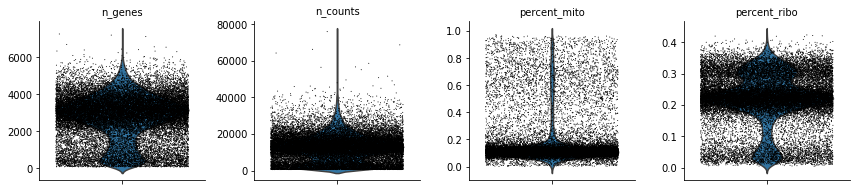

In [12]:
# identify proportions of stressed cells
axs = sc.pl.violin(adata1, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'],
                   jitter=0.4, multi_panel=True)

/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


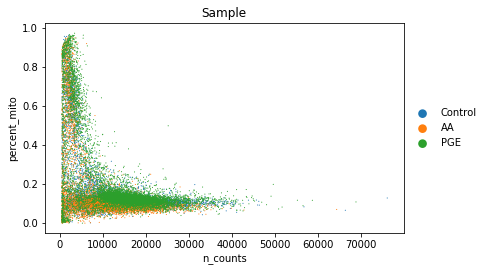

/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Applications/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Applications/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:1475: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


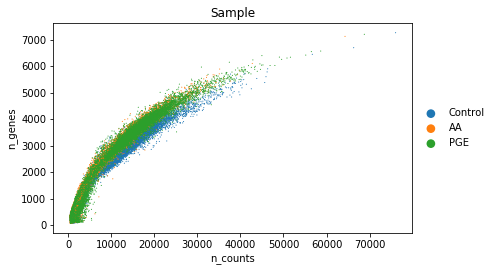

In [13]:
ax = sc.pl.scatter(adata1, x='n_counts', y='percent_mito', color='Sample')
ax = sc.pl.scatter(adata1, x='n_counts', y='n_genes', color='Sample')

In [14]:
# define cells to be exempt
n_gene_cap = 10000
n_counts_min = 4000
percent_mito_cap = 0.15

print("Cells with n_genes < " + str(n_gene_cap) + ":", len(adata1[adata1.obs['n_genes'] < n_gene_cap]))
print("Cells with n_genes > " + str(n_gene_cap) + ":", len(adata1[adata1.obs['n_genes'] > n_gene_cap]))
print()
print("Cells with n_counts_min < " + str(n_counts_min) + ":", len(adata1[adata1.obs['n_counts'] < n_counts_min]))
print("Cells with n_counts_min > " + str(n_counts_min) + ":", len(adata1[adata1.obs['n_counts'] > n_counts_min]))
print()
print("Cells with percent_mito < " + str(percent_mito_cap) + ":", len(adata1[adata1.obs['percent_mito'] < percent_mito_cap]))
print("Cells with percent_mito > " + str(percent_mito_cap) + ":", len(adata1[adata1.obs['percent_mito'] > percent_mito_cap]))

Cells with n_genes < 10000: 26434
Cells with n_genes > 10000: 0

Cells with n_counts_min < 4000: 4277
Cells with n_counts_min > 4000: 22157

Cells with percent_mito < 0.15: 20866
Cells with percent_mito > 0.15: 5568


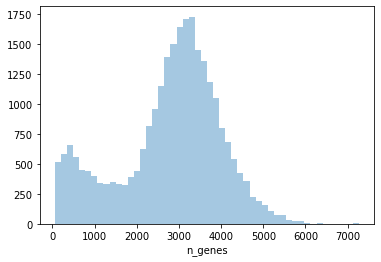

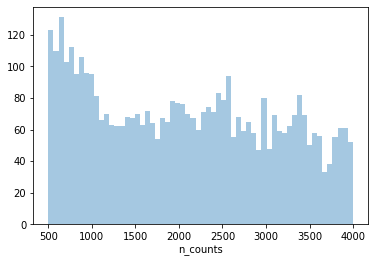

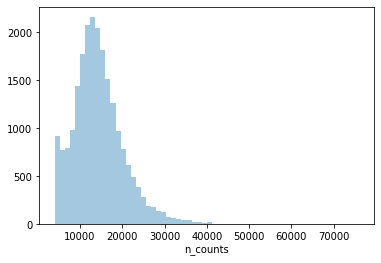

In [15]:
#Thresholding decision: counts
p3 = sb.distplot(adata1.obs['n_genes'], kde=False)
plt.show()

p4 = sb.distplot(adata1.obs['n_counts'][adata1.obs['n_counts']<4000], kde=False, bins=60)
plt.show()

p5 = sb.distplot(adata1.obs['n_counts'][adata1.obs['n_counts']>4000], kde=False, bins=60)
plt.show()

In [16]:
# filter cell sample
print("Number of cells before filtering:",len(adata1))
adata1 = adata1[adata1.obs['n_genes'] < n_gene_cap, :]
adata1 = adata1[adata1.obs['percent_mito'] < percent_mito_cap, :]
adata1 = adata1[adata1.obs['n_counts'] > n_counts_min, :]
print("Number of cells after filtering:",len(adata1))

Number of cells before filtering: 26434
Number of cells after filtering: 19611


In [17]:
# filter gene sample
print("Number of cells before filtering:",len(adata1))
#adata1 = adata1[adata1.obs['n_genes'] > 1000, :]
print("Number of cells after filtering:",len(adata1))

Number of cells before filtering: 19611
Number of cells after filtering: 19611


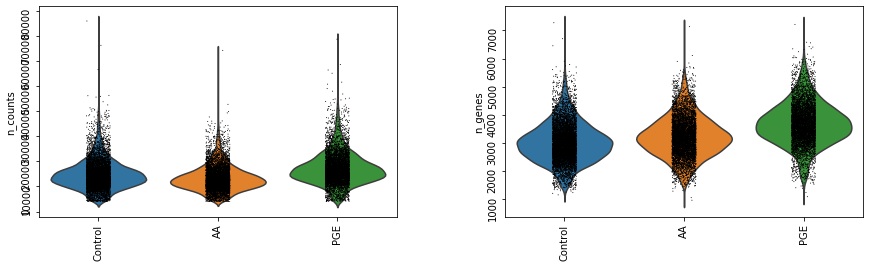

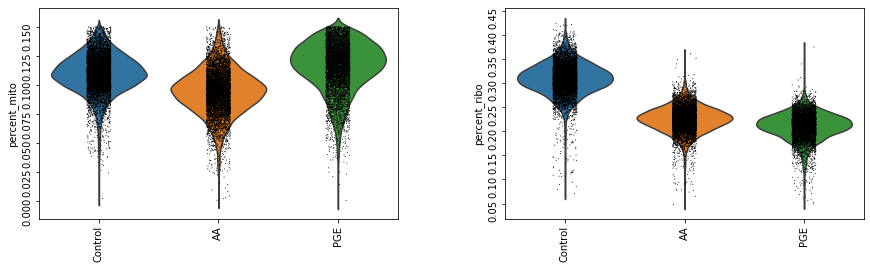

In [18]:
# view sample distributions to ensure filtering was accurate 
sc.pl.violin(adata1, groupby='Sample', keys=['n_counts','n_genes'], rotation=90)
sc.pl.violin(adata1, groupby='Sample', keys=['percent_mito','percent_ribo'], rotation=90)

In [19]:
# view dimensions of the annotated data matrix
adata1.shape

(19611, 16675)

GENE LEVEL ANALYSIS
calculate gene specific expression values to identify correlations

In [20]:
# define genes/gene sets for gene level analysis
marker_genes = dict()
# single genes
marker_genes['S'] = ['S100a6']
marker_genes['T'] = ['Fabp1']
marker_genes['X'] = ['Ctnnb1']
marker_genes['B'] = ['Apc']
marker_genes['V'] = ['Scd1']
marker_genes['K'] = ['Myc']
marker_genes['l'] = ['Lgr5']
marker_genes['l'] = ['Lgr5']
marker_genes['h'] = ['Hopx']
marker_genes['si'] = ['Siah1a']
marker_genes['A'] = ['Id2']
# 90 somthing ß Catenin target Genes from HFD paper
marker_genes['BCT'] = [ 'Fabp1','S100a6','Adam10','Ascl2','Bambi','Bcl2l2','Bcl2l1','Birc5','Bmi1','Ccnd1','Cd44','Cdx1','Dnmt1','Edn1','Enc1','Ephb2','Ephb3','Fgfbp1','Nedd9','Hes1','Id2','Lamc2','Met','Mmp14','Mmp7','Myb','Myc','Plaur','Ppard','Smc3','Sp5','Srsf3','Suz12','Tiam1','Yap1','Ccnd3','Ctnnb1','Rnf43','Lrp6','Lrp5','Olfm4','Rac1','Cldn15','Efnb2','Ephb4','Tcf7','Smc2','S100a6','Cdh1','Actb']
# custom gene sets 
marker_genes['test'] = ['Gapdh']
marker_genes['ex'] = ['Efnb1','Tcf4','Jun','L1cam','Lgr5','Mycbp','Sox9','Nedd8','Gapdh']
marker_genes['CSC'] = ['Cd24','Cd133','Cd44','Cd29','Cd90','Esa','Aldh1']
marker_genes['Wnt'] = ['Lgr5', 'Rnf43', 'Lrp6', 'Axin1', 'Apc', 'Gsk3b', 'Ctnnb1', 'Tcf7l2',  'Fbxw7']
marker_genes['diff'] = ['Bmp1','Smad7','Bmp2','Bmp5','Bmp7','Bmpr2']
marker_genes['Wnt1'] = ['Lgr5', 'Rnf43', 'Ctnnb1','Ccnd1','Id2', 'Ephb2', 'Olfm4', 'Slc12a2','Ascl2', 'Ephb2', 'Cldn4','Rnf11', 'Rnf186','Acaa2','Hmgcs2'   ]
marker_genes['bcat'] = ['Lgr5', 'Rnf43', 'Ctnnb1','Ccnd1','Id2', 'Ephb2', 'Olfm4', 'Slc12a2','Ascl2', "Hopx",'Ephb2', 'Cldn4','Id2'   ]


In [21]:
# copy current data into another annotated data set so that we can come back to gene level analysis after differential expression analysis
genedata = adata1.copy()

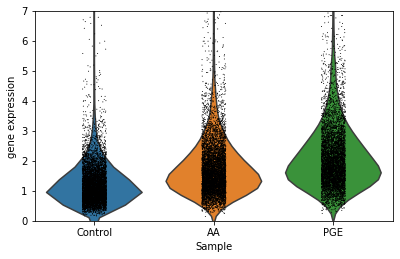

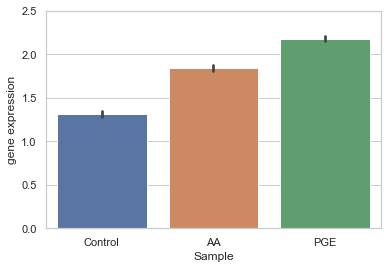

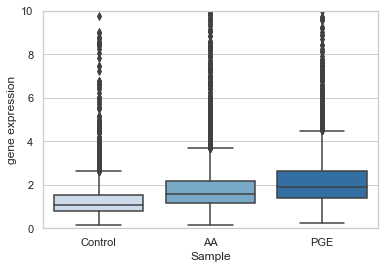

In [22]:
# define gene sets you want to identify
ids_entprox = np.in1d(genedata.var_names, marker_genes['BCT'])
ids_entdist = np.in1d(genedata.var_names, marker_genes['BCT'])
ids_ent = np.logical_or(ids_entprox, ids_entdist)

#Calculate the mean expression of gene set
genedata.obs['gene expression'] = genedata.X[:,ids_ent].mean(1)

#Plot gene expression
ax = sc.pl.violin(genedata, 'gene expression', groupby='Sample', show=False)
ax = (ax.set(ylim=(0,7)))
plt.show()
# geene expression barplots, error bars represent standard error
sb.set(style="whitegrid")
ax = sb.barplot(x="Sample", y="gene expression", data=genedata.obs, )
ax = (ax.set(ylim=(0,2.5)))
plt.show()

# box plot, diamonds represent outliers
bx = sb.boxplot( x=genedata.obs['Sample'], y=genedata.obs['gene expression'], palette="Blues")
bx = (bx.set(ylim=(0,10)))
plt.show()